In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
import xarray as xr
import numpy as np

In [9]:
# geomedian
import datacube
dc = datacube.Datacube()
ds = dc.find_datasets(product='ls8_nbart_geomedian_annual',y =(-35.1,-35.0), x = (149.0, 149.2), time=('2018-01-01','2018-01-02'))
ds[0]

Dataset <id=a016e1d8-0001-4716-a5c4-c53bfd9eed20 type=ls8_nbart_geomedian_annual location=file:///g/data/fk4/datacube/002/stats/geomedian/annual/ls8_gm/15_-40/LS8_GM_NBART_15_-40_20180101.nc>

## load data

In [22]:
!ls ../composite_median/s1_filtered_geomedian/*2018_-1_-35.nc

../composite_median/s1_filtered_geomedian/S1_2018_-1_-35.nc


In [101]:
tile = '15_-40'
tile = '-11_-35'
gm = xr.open_dataset('/g/data/fk4/datacube/002/stats/geomedian/annual/ls8_gm/%s/LS8_GM_NBART_%s_20180101.nc'%(tile, tile))

In [102]:
s1 = xr.open_dataset('../composite_median/s1_filtered_geomedian/S1_2018_%s.nc'%(tile))

In [103]:
data = gm[['blue','green','red','nir','swir1','swir2']].squeeze().to_array(dim='variable').transpose('y','x','variable').values
orig_shape = data.shape
data = data.reshape(orig_shape[0]*orig_shape[1],orig_shape[2])

In [104]:
output = s1.to_array(dim='variable').transpose('y','x','variable').values
output_shape = output.shape
output = output.reshape(output_shape[0]*output_shape[1],output_shape[2])

In [105]:
# train on valid data
good = (~np.isnan(data).all(axis=-1)) & (~np.isnan(output).all(axis=-1))

In [252]:
train_size = int(output.shape[0]/200)
train_size

80000

In [253]:
ind = np.random.choice(np.arange(good.sum()), size=train_size)
X, Y = data[good][ind, :], output[good][ind, :]

In [254]:
X.min(), X.max(), Y.min(), Y.max()

(163.0, 6651.0, 0.0010856406, 1.0533625)

In [255]:
Y.std(axis=0), output.std(axis=0)

(array([0.01509365, 0.0035287 ], dtype=float32),
 array([0.0155745 , 0.00394928], dtype=float32))

In [256]:
scaler_x = StandardScaler().fit(data[good])
scaled_x = scaler_x.transform(X)
scaler_y = StandardScaler().fit(output[good])
scaled_y = scaler_y.transform(Y)

In [257]:
scaled_x.mean(axis=0), scaled_y.mean(axis=0)

(array([0.00178204, 0.00233993, 0.00460674, 0.00660817, 0.00488542,
        0.00505214], dtype=float32),
 array([-0.00120793, -0.00105774], dtype=float32))

## single layer model

In [267]:
def singlelayer_model(loss='mse'):
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=6, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss=loss, optimizer='adam')
    return model

loss = 'mean_squared_error'
#loss = 'mean_squared_logarithmic_error'
model = singlelayer_model(loss = loss)
model.fit(scaled_x, scaled_y, epochs = 100, batch_size=10, verbose=0)


0.5653329885131679


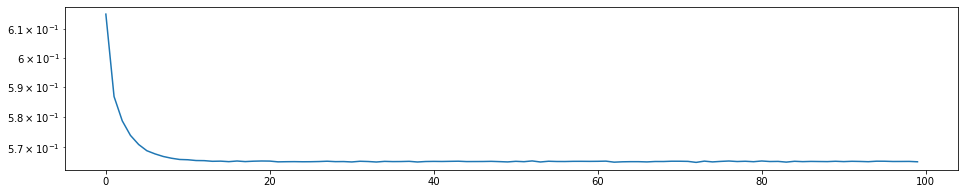

In [269]:
plt.figure(figsize=(16,3))
plt.plot(model.history.history['loss'])
plt.yscale('log')
print(model.history.history['loss'][-1])

In [270]:
%%time
predicted = model.predict(scaler_x.transform(data))

CPU times: user 5min 47s, sys: 5.48 s, total: 5min 52s
Wall time: 4min 18s


In [271]:
predicted = scaler_y.inverse_transform(predicted)
s1['predicted_vv'] = ('y','x'), predicted[:,0].reshape(orig_shape[0], orig_shape[1])
s1['predicted_vh'] = ('y','x'), predicted[:,1].reshape(orig_shape[0], orig_shape[1])

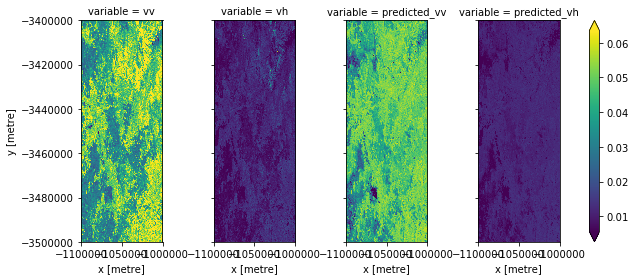

In [272]:
s1.to_array(dim='variable').plot.imshow(col='variable', robust=True, figsize=(10,4));

In [209]:
s1.mean()

<xarray.Dataset>
Dimensions:       ()
Data variables:
    vv            float32 0.045863762
    vh            float32 0.011100499
    predicted_vv  float32 0.045707375
    predicted_vh  float32 0.011091964

## multi-layer model

In [258]:
%%time

def baseline_model(loss=loss):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal',activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss=loss, optimizer='adam')
    return model

# evaluate model with standardized dataset
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10, verbose=1)))
#pipeline = Pipeline(estimators)
#kfold = KFold(n_splits=5)
#results = cross_val_score(pipeline, X, Y, cv=kfold)
#print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))
#pipeline.fit(X,Y)

loss = 'mean_squared_error'
#loss = 'mean_squared_logarithmic_error'
bmodel = baseline_model(loss = loss)
bmodel.fit(scaled_x, scaled_y, epochs = 250, batch_size=10, verbose=0)

CPU times: user 1h 28min 30s, sys: 19min 23s, total: 1h 47min 54s
Wall time: 1h 15min 41s


0.4040353413396515


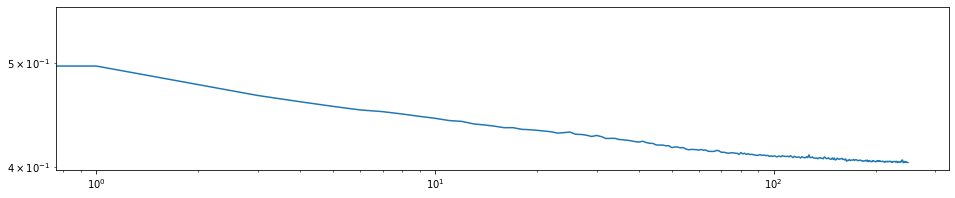

In [259]:
plt.figure(figsize=(16,3))
plt.plot(bmodel.history.history['loss'])
plt.yscale('log')
plt.xscale('log')
print(bmodel.history.history['loss'][-1])

In [260]:
%%time
predicted = bmodel.predict(scaler_x.transform(data))

CPU times: user 10min 15s, sys: 2min 34s, total: 12min 50s
Wall time: 7min 58s


In [261]:
predicted = scaler_y.inverse_transform(predicted)
s1['predicted_vv'] = ('y','x'), predicted[:,0].reshape(orig_shape[0], orig_shape[1])
s1['predicted_vh'] = ('y','x'), predicted[:,1].reshape(orig_shape[0], orig_shape[1])

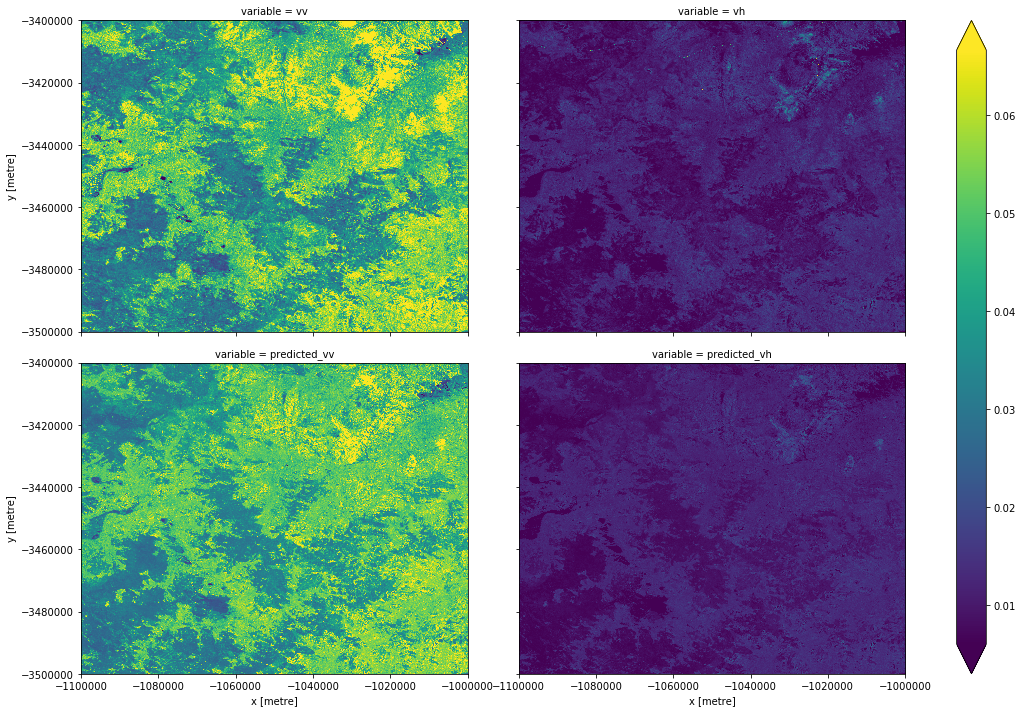

In [262]:
s1.to_array(dim='variable').plot.imshow(col='variable', robust=True, figsize=(16,10), col_wrap=2);

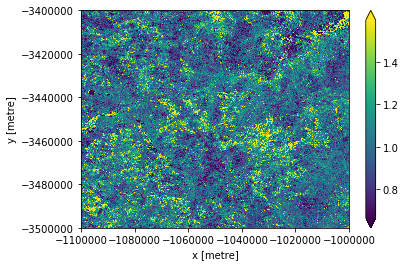

In [263]:
(s1.predicted_vh/s1.vh).plot.imshow(robust=True);

## measure translation

In [264]:
from skimage.feature import register_translation

In [265]:
shift_vv = register_translation(s1.predicted_vv.values, s1.vv.values, 100, return_error=False)
shift_vv

array([0.36, 0.19])

In [266]:
shift_vh = register_translation(s1.predicted_vh.values, s1.vh.values, 100, return_error=False)
shift_vh

array([0.35, 0.23])

In [236]:
gm.red.values.shape, s1.vv.values.shape

((1, 4000, 4000), (4000, 4000))

In [237]:
shift_op = register_translation(1/gm.blue.squeeze().values, s1.vv.values, 100, return_error=False)
print(shift_op)
shift_op = register_translation(1/gm.red.squeeze().values, s1.vv.values, 100, return_error=False)
print(shift_op)
shift_op = register_translation(1/gm.green.squeeze().values, s1.vv.values, 100, return_error=False)
print(shift_op)


[0.59 0.01]
[0.51 0.08]
[0.57 0.07]
